In [1]:
import numpy as np
import pandas as pd
import pdb

# LSTM with 120 window size

In [2]:
kospi200 = np.load('./data/kospi200.npy',allow_pickle=True)
samsung = np.load('./data/samsung.npy',allow_pickle=True)

In [3]:
def split_xy_window(dataset, time_steps, y_column):
    x,y = [],[]
    for i in range(len(dataset)):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column
        
        if y_end_number>len(dataset):
            break
        tmp_x = dataset[i:x_end_number,:]
        tmp_y = dataset[x_end_number:y_end_number,3]
        x.append(tmp_x)
        y.append(tmp_y)
    return np.array(x), np.array(y)

In [4]:
# time step = 120
x,y = split_xy_window(samsung,120,1)
print(x.shape,y.shape,sep='\n')

(306, 120, 5)
(306, 1)


In [8]:
from sklearn.model_selection import train_test_split
# train-test split
x_train, x_test, y_train, y_test = train_test_split(
    x,y,random_state=1, test_size=0.3)
# reshape datasets to 1 dimension or preprocessing
x_train = np.reshape(x_train,
                    (x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
x_test = np.reshape(x_test,
                   (x_test.shape[0],x_test.shape[1]*x_test.shape[2]))
print(x_train.shape,
     x_test.shape,
     sep='\n')
# preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
# print(x_train_scaled[0,:])

(214, 600)
(92, 600)


In [9]:
# reshape to (None,5,5)
x_train = np.reshape(x_train_scaled,
                    (x_train_scaled.shape[0],120,5))
x_test = np.reshape(x_test_scaled,
                    (x_test_scaled.shape[0],120,5))
print(x_train.shape, x_test.shape, sep='\n') 
# batch_size, time_step, features

(214, 120, 5)
(92, 120, 5)


In [16]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from torch.optim.lr_scheduler import ReduceLROnPlateau

import copy
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False
    
class LSTMModel(nn.Module):
    def __init__(self,input_dim):
        super(LSTMModel,self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_size=64, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.seq = nn.Sequential(nn.Linear(64,32),
                                nn.ReLU(),
                                nn.Linear(32,32),
                                nn.ReLU(),
                                nn.Linear(32,32),
                                nn.ReLU(),
                                nn.Linear(32,32),
                                nn.ReLU(),
                                nn.Linear(32,1)
                                )
        
    def forward(self,x):
        x,_ = self.lstm(x)
#         print('output of lstm :',x.size()) # torch.Size([1, 120, 64])
        x = self.dropout(x[:,-1,:])
#         print('from lstm to linear :',x.size()) # torch.Size([1, 64])
        x = self.seq(x)
        return x
    
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [17]:
model = LSTMModel(x_train.shape[2])

In [18]:
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=20,verbose=True)

In [19]:
# to DataLoader
x_tr, x_val, y_tr, y_val = train_test_split(x_train,y_train,
                                           random_state=1,test_size=0.2)

# to tensor
x_tr_tensor = torch.tensor(x_tr.astype(np.float32),dtype=torch.float32)
x_val_tensor = torch.tensor(x_val.astype(np.float32),dtype=torch.float32)
y_tr_tensor = torch.tensor(y_tr.astype(np.float32),dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.astype(np.float32),dtype=torch.float32)

# to DataLoader
batch_size = 1
train_loader = DataLoader(TensorDataset(x_tr_tensor,y_tr_tensor),
                         batch_size=batch_size,shuffle=True)
val_loader = DataLoader(TensorDataset(x_val_tensor,y_val_tensor),
                       batch_size=batch_size,shuffle=False)

In [20]:
EPOCHS = 1000
epoch_counter = 0
patience = 30
best_loss = float('inf')
done = False
es = EarlyStopping(patience=patience)
tr_losses_fp, val_losses_fp = [],[]

while not done and epoch_counter<EPOCHS:
    epoch_counter+=1
    
    # train
    model.train()
    train_losses = []
    for x_batch,y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output,y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    tr_losses_fp.append(train_loss)
    
    # validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            output = model(x_batch)
            loss = criterion(output, y_batch)
            val_losses.append(loss.item())
    val_loss = np.mean(val_losses)
    val_losses_fp.append(val_loss)
    scheduler.step(val_loss)
    
    if es(model, val_loss):
        done = True
    
    print(f"Epoch {epoch_counter}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/1000, Train Loss: 45468.2123, Validation Loss: 37355.4172
Epoch 2/1000, Train Loss: 9644.0673, Validation Loss: 5144.7165
Epoch 3/1000, Train Loss: 4084.2634, Validation Loss: 3549.0591
Epoch 4/1000, Train Loss: 3820.5232, Validation Loss: 2268.1059
Epoch 5/1000, Train Loss: 3183.7887, Validation Loss: 2134.4181
Epoch 6/1000, Train Loss: 2915.0247, Validation Loss: 1203.6721
Epoch 7/1000, Train Loss: 2744.7554, Validation Loss: 2288.4299
Epoch 8/1000, Train Loss: 2804.8462, Validation Loss: 1344.4634
Epoch 9/1000, Train Loss: 2867.0387, Validation Loss: 1282.8363
Epoch 10/1000, Train Loss: 2865.6590, Validation Loss: 931.5067
Epoch 11/1000, Train Loss: 2815.0754, Validation Loss: 1459.5225
Epoch 12/1000, Train Loss: 2798.7390, Validation Loss: 2071.5561
Epoch 13/1000, Train Loss: 2518.5508, Validation Loss: 1451.7275
Epoch 14/1000, Train Loss: 2729.6348, Validation Loss: 1013.4928
Epoch 15/1000, Train Loss: 2863.4155, Validation Loss: 877.6778
Epoch 16/1000, Train Loss: 2471.51

Epoch 127/1000, Train Loss: 2668.4662, Validation Loss: 705.0769
Epoch 128/1000, Train Loss: 2395.5961, Validation Loss: 540.3834
Epoch 129/1000, Train Loss: 2474.3302, Validation Loss: 539.8159
Epoch 130/1000, Train Loss: 2735.7991, Validation Loss: 596.9511
Epoch 131/1000, Train Loss: 2404.5643, Validation Loss: 572.4043
Epoch 132/1000, Train Loss: 2269.6567, Validation Loss: 558.5342
Epoch 133/1000, Train Loss: 2282.1380, Validation Loss: 569.0955
Epoch 134/1000, Train Loss: 2082.8967, Validation Loss: 697.5546
Epoch 135/1000, Train Loss: 2470.8792, Validation Loss: 568.3072
Epoch 136/1000, Train Loss: 2267.9897, Validation Loss: 620.5943
Epoch 137/1000, Train Loss: 2375.7612, Validation Loss: 548.6372
Epoch 138/1000, Train Loss: 2419.6192, Validation Loss: 677.0407
Epoch 139/1000, Train Loss: 2474.7675, Validation Loss: 716.3037
Epoch 140/1000, Train Loss: 2466.5499, Validation Loss: 564.8491
Epoch 141/1000, Train Loss: 2406.6629, Validation Loss: 763.9447
Epoch 142/1000, Train Los

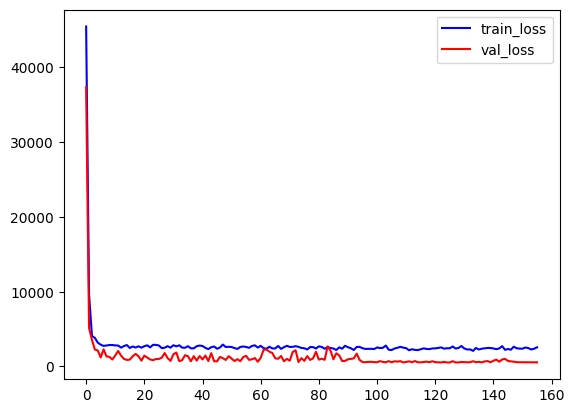

In [21]:
import matplotlib.pyplot as plt
plt.plot(range(len(tr_losses_fp)),tr_losses_fp,color='blue',label='train_loss')
plt.plot(range(len(val_losses_fp)),val_losses_fp,color='red',label='val_loss')
plt.legend()
plt.show()

In [22]:
# evaluation
model.eval()
with torch.no_grad():
    x_test_tensor = torch.tensor(x_test.astype(np.float32),dtype=torch.float32)
    pred = model(x_test_tensor)

In [23]:
pred_np = pred.detach().numpy()

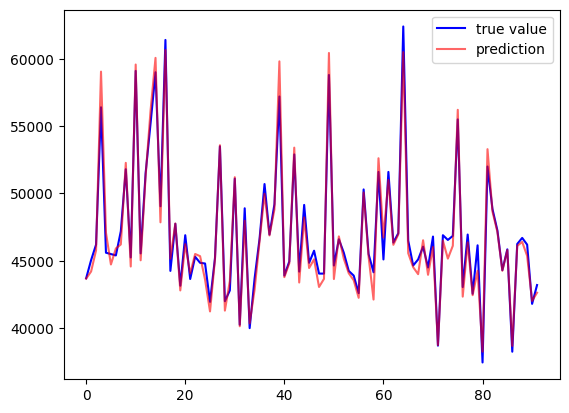

In [24]:
r = len(np.reshape(y_test,(-1)))
plt.plot(list(range(r)),np.reshape(y_test,(-1)), color='blue', label='true value')
plt.plot(list(range(r)),np.reshape(pred_np,(-1)), color='red',alpha=0.6, label='prediction')
plt.legend()
plt.show()